# Capstone Project: Comment Subtopics Analysis for Airbnb Hosts
---

How can a host on Airbnb understand that are their strengths and weaknesses? How can hosts point out the demand trend of their customers from a large scale of comments? This project focuses on using machine learning tools to help hosts understand the underlying trends of the comments on their property.  

---


# Part 3: LDA Analysis On Location 

- Since Location is always an important features in determining the qualify of the house, in this notebook, I will focus on examine if there is any difference key features that distingush one location from the others. 
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

from gensim import corpora, models
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

np.random.seed(42)

In [3]:
reviews = pd.read_csv('../data/reviews_sentiment_score.csv', index_col = 0)

In [4]:
reviews.head()

,key_0,listing_id,id,date,reviewer_id,reviewer_name,comments,language,compound,neg,neu,pos
0,0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st...",en,0.9590,0.000,0.788,0.212
1,1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...,en,0.9819,0.000,0.697,0.303
2,2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...,en,0.7600,0.134,0.710,0.156
3,3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...,en,0.9840,0.035,0.646,0.319
4,4,958,26008,2010-02-13,15416,Venetia,Holly's place was great. It was exactly what I...,en,0.9617,0.000,0.613,0.387


In [5]:
reviews.dtypes

key_0              int64
listing_id         int64
id                 int64
date              object
reviewer_id        int64
reviewer_name     object
comments          object
language          object
compound         float64
neg              float64
neu              float64
pos              float64
dtype: object

In [6]:
len(set(reviews['listing_id']))

4199

In [7]:
listing = pd.read_csv('../data/listings/2019-03-06_data_listings.csv')

In [8]:
listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,958,https://www.airbnb.com/rooms/958,20190306152813,2019-03-06,"Bright, Modern Garden Unit - 1BR/1B",New update: the house next door is under const...,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,none,*Quiet cul de sac in friendly neighborhood *St...,...,t,f,moderate,f,f,1,1,0,0,1.54
1,5858,https://www.airbnb.com/rooms/5858,20190306152813,2019-03-06,Creative Sanctuary,NaN,We live in a large Victorian house on a quiet ...,We live in a large Victorian house on a quiet ...,none,I love how our neighborhood feels quiet but is...,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.93
2,7918,https://www.airbnb.com/rooms/7918,20190306152813,2019-03-06,A Friendly Room - UCSF/USF - San Francisco,Nice and good public transportation. 7 minute...,Room rental-sunny view room/sink/Wi Fi (inner ...,Nice and good public transportation. 7 minute...,none,"Shopping old town, restaurants, McDonald, Whol...",...,f,f,strict_14_with_grace_period,f,f,9,0,9,0,0.15
3,8142,https://www.airbnb.com/rooms/8142,20190306152813,2019-03-06,Friendly Room Apt. Style -UCSF/USF - San Franc...,Nice and good public transportation. 7 minute...,Room rental Sunny view Rm/Wi-Fi/TV/sink/large ...,Nice and good public transportation. 7 minute...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,9,0,9,0,0.15
4,8339,https://www.airbnb.com/rooms/8339,20190306152813,2019-03-06,Historic Alamo Square Victorian,Pls email before booking. Interior featured i...,Please send us a quick message before booking ...,Pls email before booking. Interior featured i...,none,NaN,...,f,f,strict_14_with_grace_period,t,t,2,2,0,0,0.23


In [9]:
listing[['id', 'neighbourhood_cleansed']].head()

,id,neighbourhood_cleansed
0,958,Western Addition
1,5858,Bernal Heights
2,7918,Haight Ashbury
3,8142,Haight Ashbury
4,8339,Western Addition


### Overall Review Score Rating Map to Dataframe
---

In [10]:
review_rating_df = listing[['id', 'review_scores_rating']]

In [11]:
review_rating_df.isnull().sum()

id                         0
review_scores_rating    1421
dtype: int64

In [12]:
rating_dict = {}
for i, rate in zip(listing['id'],listing['review_scores_rating']):
    rating_dict[i] = rate

In [13]:
reviews['overall_rating'] = reviews['listing_id'].map(rating_dict)

In [14]:
reviews.head()

,key_0,listing_id,id,date,reviewer_id,reviewer_name,comments,language,compound,neg,neu,pos,overall_rating
0,0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st...",en,0.9590,0.000,0.788,0.212,97.0
1,1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...,en,0.9819,0.000,0.697,0.303,97.0
2,2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...,en,0.7600,0.134,0.710,0.156,97.0
3,3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...,en,0.9840,0.035,0.646,0.319,97.0
4,4,958,26008,2010-02-13,15416,Venetia,Holly's place was great. It was exactly what I...,en,0.9617,0.000,0.613,0.387,97.0


### Building Location Dictionary Map to DataFrame

---

In [15]:
location_dict = {}
for i, neighbourhood in zip(listing['id'],listing['neighbourhood_cleansed']):
    location_dict[i] = neighbourhood

In [16]:
len(location_dict)

7151

In [17]:
neighbourhood = reviews['listing_id'].map(location_dict)

In [18]:
reviews['neighbourhood'] = neighbourhood

In [19]:
reviews.head()

,key_0,listing_id,id,date,reviewer_id,reviewer_name,comments,language,compound,neg,neu,pos,overall_rating,neighbourhood
0,0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st...",en,0.9590,0.000,0.788,0.212,97.0,Western Addition
1,1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...,en,0.9819,0.000,0.697,0.303,97.0,Western Addition
2,2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...,en,0.7600,0.134,0.710,0.156,97.0,Western Addition
3,3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...,en,0.9840,0.035,0.646,0.319,97.0,Western Addition
4,4,958,26008,2010-02-13,15416,Venetia,Holly's place was great. It was exactly what I...,en,0.9617,0.000,0.613,0.387,97.0,Western Addition


In [20]:
#
neighbourhood_list = reviews['neighbourhood'].unique()

## Exame Number of Hosts for Each Location And Average Sentiment Per Host, In Each Location 

---

In [24]:
avg_sent_per_listing = reviews[['listing_id', 'compound']].groupby(by = ["listing_id"]).mean()
avg_sent_per_listing.reset_index(inplace= True)

In [25]:
avg_sent_per_listing['neighbourhood'] = avg_sent_per_listing['listing_id'].map(location_dict)

In [26]:
avg_sent_per_listing.head(10)

,listing_id,compound,neighbourhood
0,958,0.905033,Western Addition
1,5858,0.882490,Bernal Heights
2,7918,0.959018,Haight Ashbury
3,8142,0.981643,Haight Ashbury
4,8339,0.948511,Western Addition
5,8567,0.905455,Western Addition
6,8739,0.928308,Mission
7,9225,0.875336,Potrero Hill
8,10251,0.874053,Mission
9,10820,0.923806,Haight Ashbury


In [27]:
neighbourhood_count_df = avg_sent_per_listing[['neighbourhood', 'listing_id']].groupby(by = ['neighbourhood']).count()
neighbourhood_count_df.reset_index(inplace= True)

In [28]:
neighbourhood_count_df.head()

,neighbourhood,listing_id
0,Bayview,84
1,Bernal Heights,281
2,Castro/Upper Market,273
3,Chinatown,57
4,Crocker Amazon,19


### Number of Host Per Location 

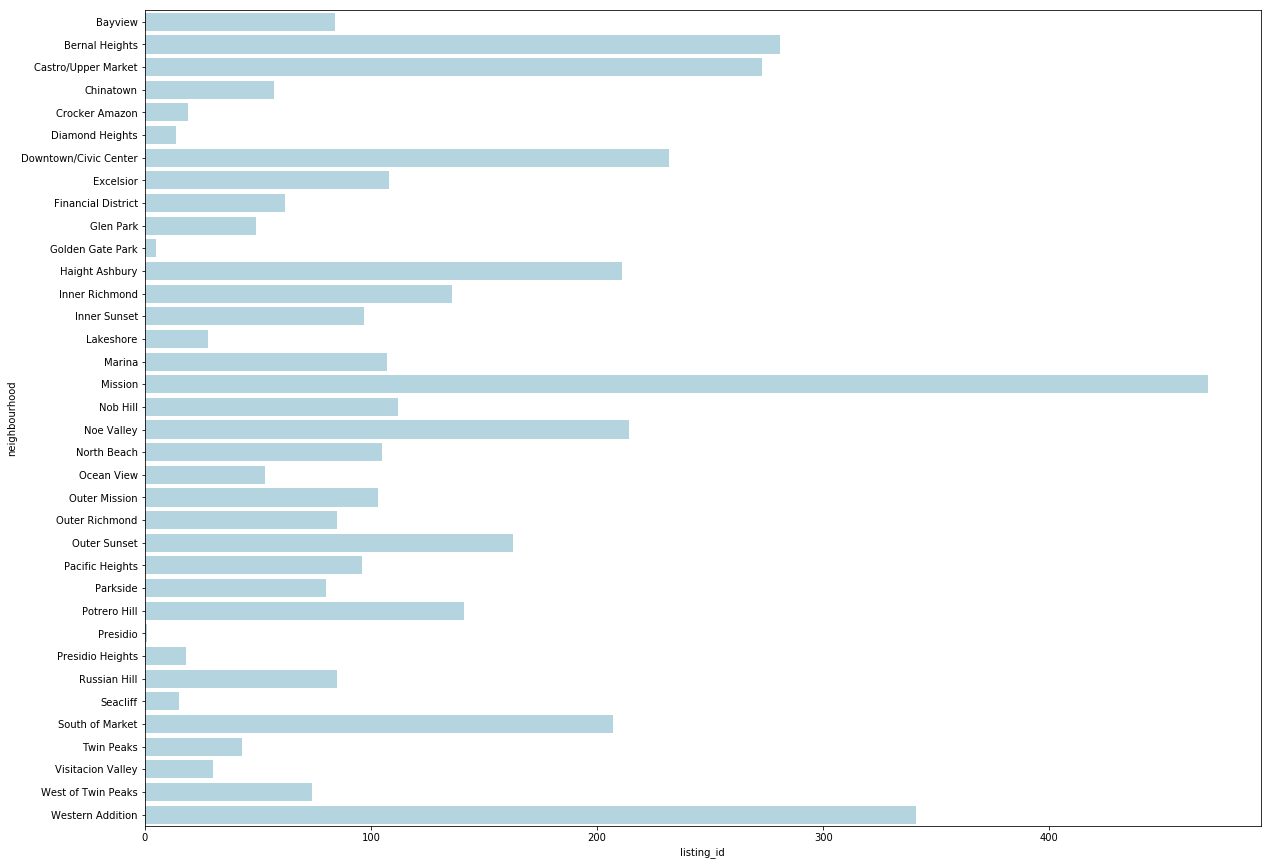

In [29]:
plt.figure(figsize = (20,15))
sns.barplot(y = neighbourhood_count_df['neighbourhood'], x = neighbourhood_count_df['listing_id'], color = "lightblue")

## Examine Average Sentiment Based On Location 
---

In [21]:
neighbourhood_sentiment = reviews[['neighbourhood', 'compound']].groupby(by = ["neighbourhood"]).mean()

In [22]:
neighbourhood_sentiment.reset_index(inplace= True)

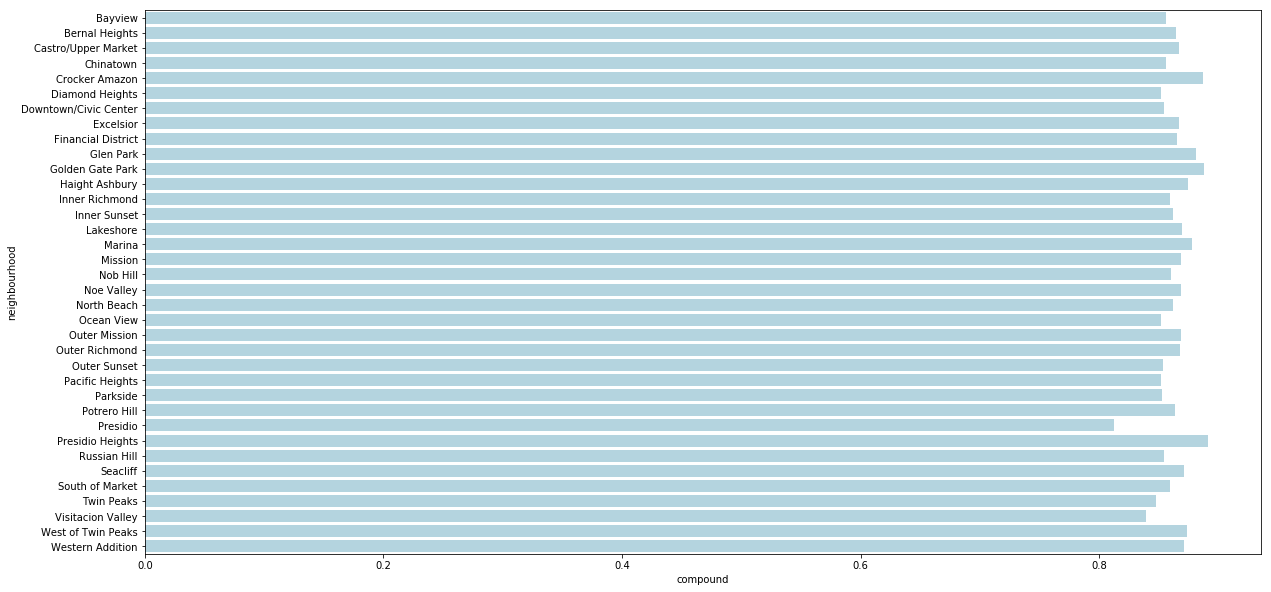

In [23]:
plt.figure(figsize = (20,10))
sns.barplot(y = neighbourhood_sentiment['neighbourhood'], x = neighbourhood_sentiment['compound'], color = "lightblue")

## Sentiment Distribution Per Location 
---

In [30]:
avg_sent_per_listing.head(10)

,listing_id,compound,neighbourhood
0,958,0.905033,Western Addition
1,5858,0.882490,Bernal Heights
2,7918,0.959018,Haight Ashbury
3,8142,0.981643,Haight Ashbury
4,8339,0.948511,Western Addition
5,8567,0.905455,Western Addition
6,8739,0.928308,Mission
7,9225,0.875336,Potrero Hill
8,10251,0.874053,Mission
9,10820,0.923806,Haight Ashbury


In [31]:
neighbourhood_list = avg_sent_per_listing['neighbourhood'].unique()
neighbourhood_list

array(['Western Addition', 'Bernal Heights', 'Haight Ashbury', 'Mission',
       'Potrero Hill', 'Downtown/Civic Center', 'Castro/Upper Market',
       'Inner Sunset', 'South of Market', 'Noe Valley', 'Nob Hill',
       'Outer Richmond', 'Presidio Heights', 'Glen Park', 'Ocean View',
       'Pacific Heights', 'Financial District', 'Twin Peaks',
       'Russian Hill', 'Outer Sunset', 'North Beach', 'Marina',
       'Inner Richmond', 'Excelsior', 'Seacliff', 'Chinatown',
       'West of Twin Peaks', 'Bayview', 'Diamond Heights',
       'Outer Mission', 'Parkside', 'Lakeshore', 'Crocker Amazon',
       'Golden Gate Park', 'Visitacion Valley', 'Presidio'], dtype=object)

In [32]:
len(neighbourhood_list)

36

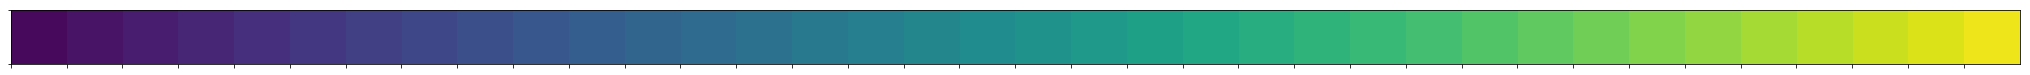

In [33]:
sns.palplot(sns.color_palette("viridis", 36))

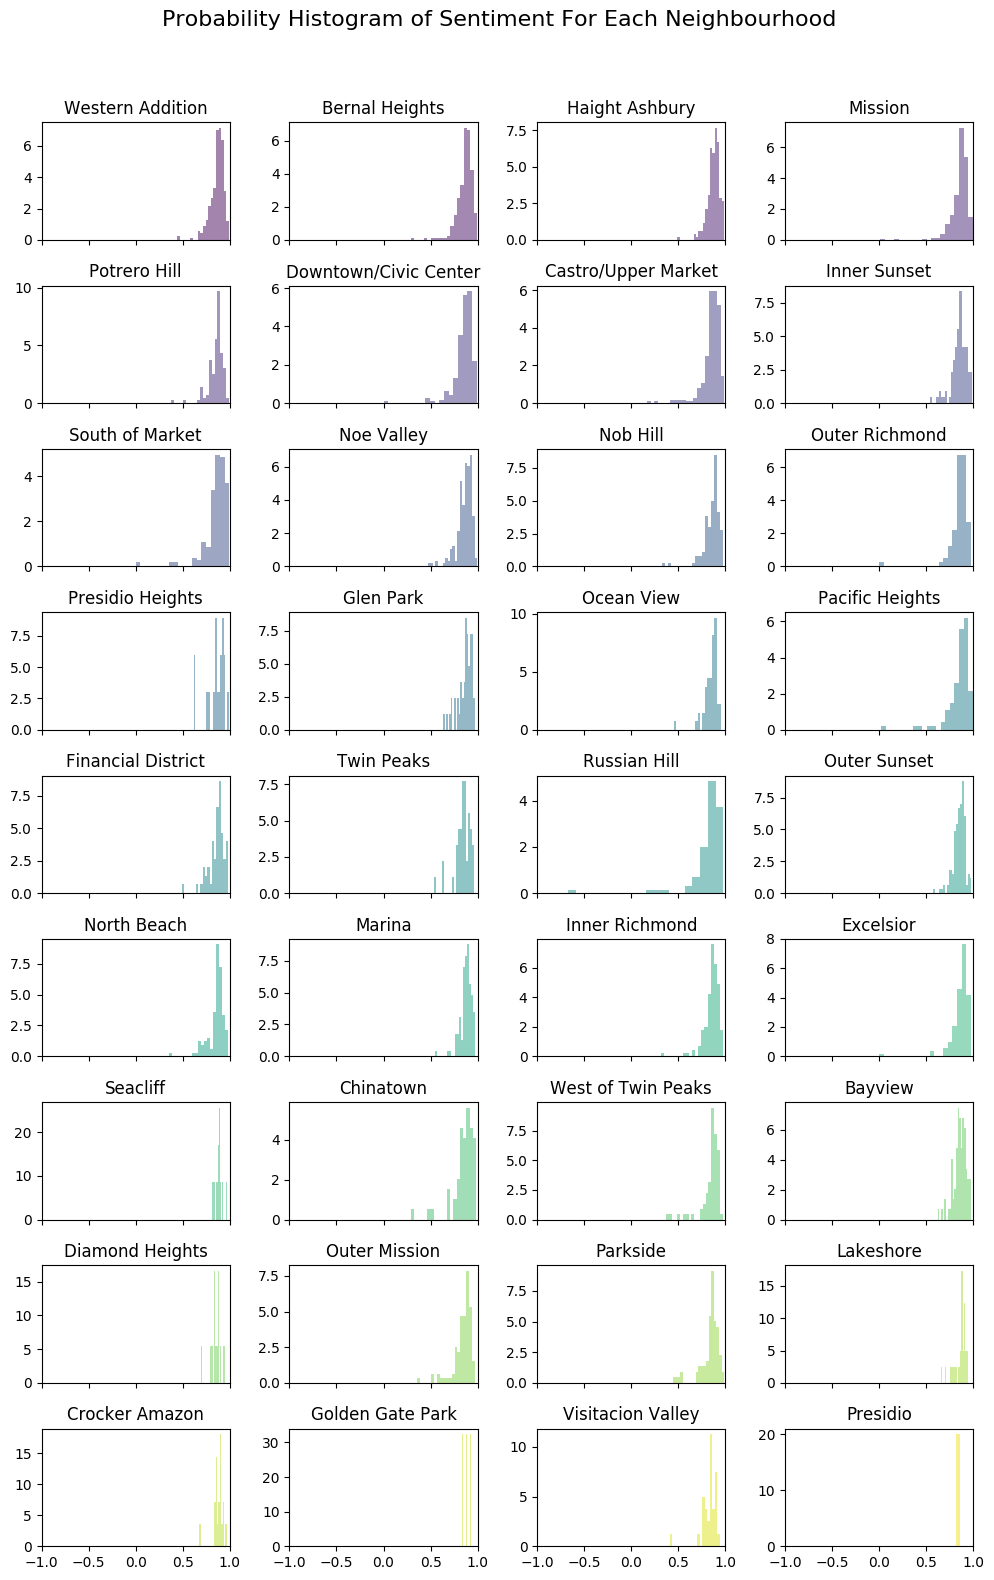

In [34]:
# Plot
fig, axes = plt.subplots(9, 4, figsize=(10,15), dpi=100, sharex=True, sharey=False)
colors = sns.color_palette("viridis", 36)

for i, (ax, neighbour) in enumerate(zip(axes.flatten(), avg_sent_per_listing['neighbourhood'].unique())):
    x = avg_sent_per_listing.loc[avg_sent_per_listing['neighbourhood']== neighbour, "compound"]
    ax.hist(x, alpha=0.5, bins=20, density=True, stacked=True, label=str(neighbour), color = colors[i])
    ax.set_title(neighbour)

plt.suptitle('Probability Histogram of Sentiment For Each Neighbourhood', y=1.05, size=16)
ax.set_xlim(-1, 1);
plt.tight_layout();

### Overall Rating Distribution For Each Location 

In [38]:
avg_rating_df = reviews[['listing_id', 'overall_rating']].groupby(by = ["listing_id"]).mean()

In [40]:
avg_rating_df.reset_index(inplace= True)

In [41]:
avg_rating_df['neighbourhood'] = avg_rating_df['listing_id'].map(location_dict)

In [42]:
avg_rating_df.head()

,listing_id,overall_rating,neighbourhood
0,958,97.0,Western Addition
1,5858,98.0,Bernal Heights
2,7918,85.0,Haight Ashbury
3,8142,93.0,Haight Ashbury
4,8339,97.0,Western Addition


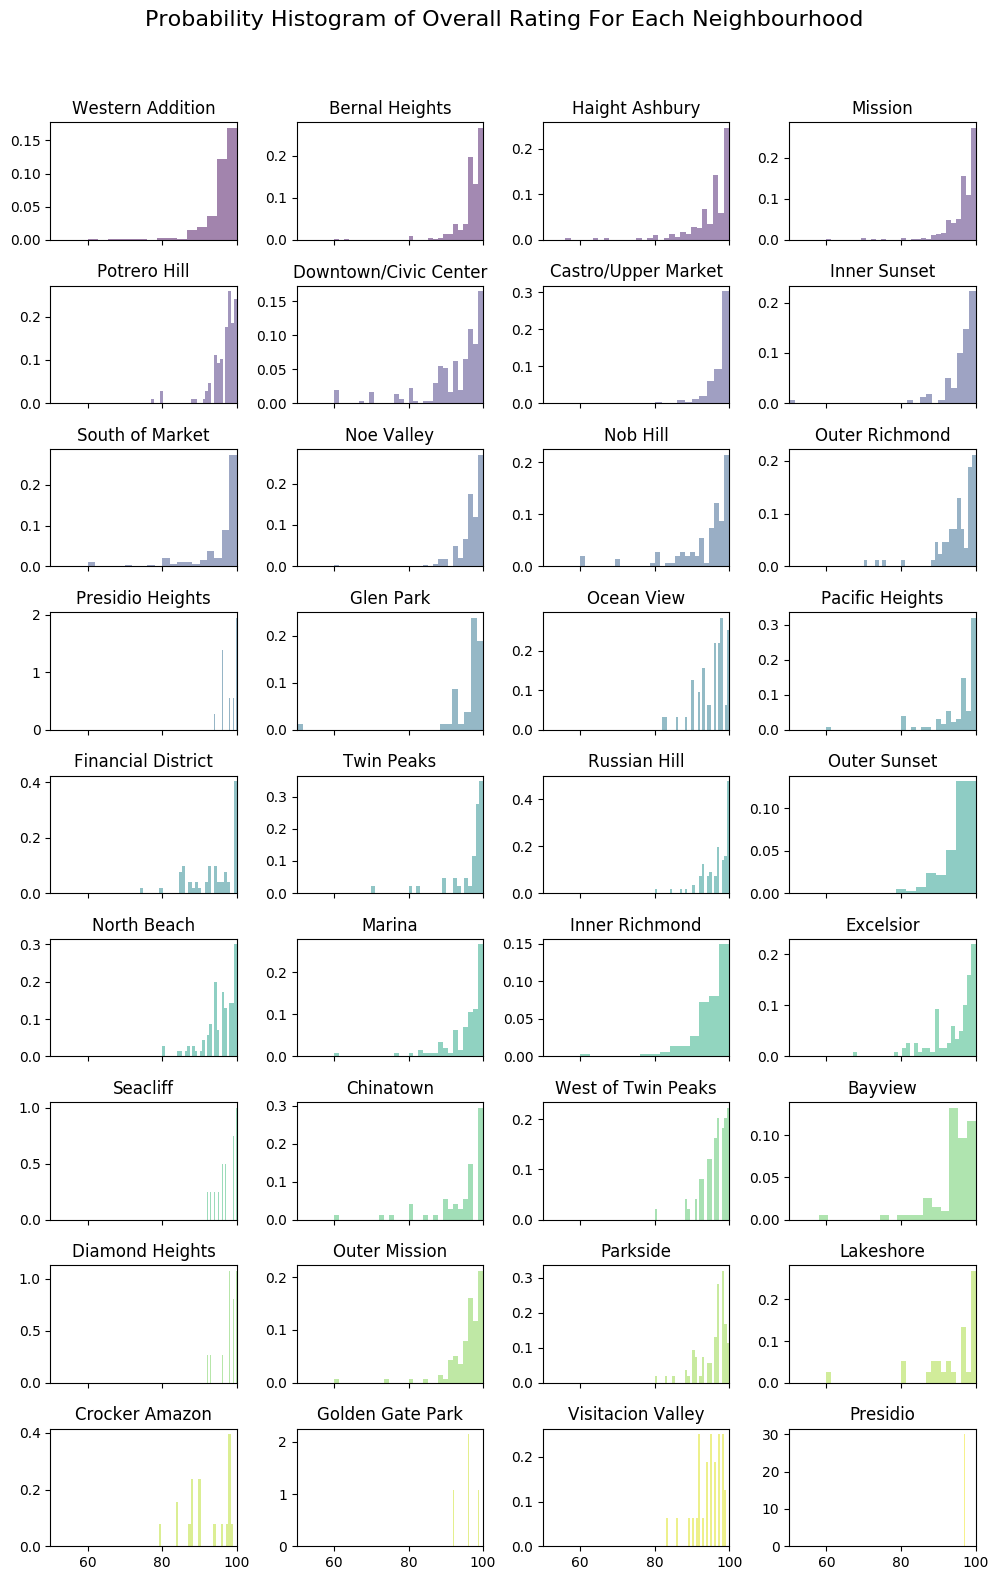

In [45]:
# Plot
fig, axes = plt.subplots(9, 4, figsize=(10,15), dpi=100, sharex=True, sharey=False)
colors = sns.color_palette("viridis", 36)

for i, (ax, neighbour) in enumerate(zip(axes.flatten(), avg_rating_df['neighbourhood'].unique())):
    x = avg_rating_df.loc[avg_rating_df['neighbourhood']== neighbour, "overall_rating"]
    ax.hist(x, alpha=0.5, bins=30, density=True, stacked=True, label=str(neighbour), color = colors[i])
    ax.set_title(neighbour)

plt.suptitle('Probability Histogram of Overall Rating For Each Neighbourhood', y=1.05, size=16)
ax.set_xlim(50, 100);
plt.tight_layout();

In [97]:
reviews[reviews['overall_rating'] < 80]

,key_0,listing_id,id,date,reviewer_id,reviewer_name,comments,language,compound,neg,neu,pos,overall_rating,neighbourhood
1789,1870,12042,4447636,2013-05-06,4053756,Filippo,Aaron was a great host during my month in San ...,en,0.9975,0.012,0.551,0.437,64.0,Haight Ashbury
1790,1871,12042,18447138,2014-08-26,18903791,Eric,Aaron is a really nice guy. If there is anythi...,en,0.9771,0.000,0.529,0.471,64.0,Haight Ashbury
1791,1872,12042,36612983,2015-06-29,35087011,Julio,Host definitely made me feel welcomed. The roo...,en,0.9750,0.000,0.368,0.632,64.0,Haight Ashbury
1792,1873,12042,41959134,2015-08-10,23947735,Bear Mommy,Aaron is very nice and welcoming. The house is...,en,0.9721,0.000,0.565,0.435,64.0,Haight Ashbury
1793,1874,12042,51195352,2015-10-18,45551282,Sachin,We had a comfortable stay in the house. The be...,en,0.9939,0.000,0.650,0.350,64.0,Haight Ashbury
3045,3168,21914,543064,2011-09-18,1098999,Pui,I was happy with my stay at Aaron's place !!! ...,en,0.9734,0.000,0.667,0.333,78.0,Haight Ashbury
3046,3169,21914,2408295,2012-09-25,1234393,Chiba,Great host! Very helpfull with information abo...,en,0.9709,0.000,0.453,0.547,78.0,Haight Ashbury
3047,3170,21914,2575788,2012-10-10,3609771,Derek,Communal / hostel type place with shared bathr...,en,0.9772,0.000,0.645,0.355,78.0,Haight Ashbury
3048,3171,21914,14102405,2014-06-11,1823147,Sneha,"Very nice guy, gave me a tour, and chatted wit...",en,0.9690,0.023,0.766,0.210,78.0,Haight Ashbury
3049,3172,21914,18242184,2014-08-24,15236719,Alain,"Aaron was a great host, and very accommodating...",en,0.9824,0.000,0.723,0.277,78.0,Haight Ashbury


## LDA Analysis Based On Different Location
---

In [46]:
neighbourhood_list

array(['Western Addition', 'Bernal Heights', 'Haight Ashbury', 'Mission',
       'Potrero Hill', 'Downtown/Civic Center', 'Castro/Upper Market',
       'Inner Sunset', 'South of Market', 'Noe Valley', 'Nob Hill',
       'Outer Richmond', 'Presidio Heights', 'Glen Park', 'Ocean View',
       'Pacific Heights', 'Financial District', 'Twin Peaks',
       'Russian Hill', 'Outer Sunset', 'North Beach', 'Marina',
       'Inner Richmond', 'Excelsior', 'Seacliff', 'Chinatown',
       'West of Twin Peaks', 'Bayview', 'Diamond Heights',
       'Outer Mission', 'Parkside', 'Lakeshore', 'Crocker Amazon',
       'Golden Gate Park', 'Visitacion Valley', 'Presidio'], dtype=object)

In [47]:
reviews[reviews['neighbourhood'] == neighbourhood_list[0]]['comments'].head()

0    Our experience was, without a doubt, a five st...
1    Returning to San Francisco is a rejuvenating t...
2    We were very pleased with the accommodations a...
3    We highly recommend this accomodation and agre...
4    Holly's place was great. It was exactly what I...
Name: comments, dtype: object

In [48]:
#Western Addition LDA Analysis 
cv = CountVectorizer(ngram_range= (2,3), 
                     stop_words= 'english', 
                     min_df = 2)
cv_transform = cv.fit_transform(reviews[reviews['neighbourhood'] == neighbourhood_list[0]]['comments'])

In [49]:
cv_df =  pd.DataFrame(cv_transform.toarray(), columns = cv.get_feature_names())

In [50]:
texts = [cv_df.columns[cv_df.loc[index,:].nonzero()] for index in cv_df.index]

/Users/evelyn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  """Entry point for launching an IPython kernel.


In [51]:
dictionary = corpora.Dictionary(texts)

In [52]:
corpus = [dictionary.doc2bow(text) for text in texts]

## LDA Run
---

## Notes : 
- break down starts and aggreagte the result to see what are the key topics in each level of stars. (most common charaterictic of subtopics for each host)
- measurement of accuracy; use actual post to back up the finding of each star's subtopic. 
- metric for LDA, how do you evaluate to determine the success of the measure. 


In [69]:
def lda_function(df, location, n_topic): 
    cv = CountVectorizer(ngram_range= (2,3), 
                     stop_words= 'english', 
                     min_df = 2)
    
    cv_transform = cv.fit_transform(df[df['neighbourhood'] == location]) 

    cv_df =  pd.DataFrame(cv_transform.toarray(), columns = cv.get_feature_names())

    texts = [cv_df.columns[cv_df.loc[index,:].nonzero()] for index in cv_df.index]

    dictionary = corpora.Dictionary(texts)

    corpus = [dictionary.doc2bow(text) for text in texts]

    ldamodel = models.ldamodel.LdaModel(corpus, 
                                        id2word = dictionary, 
                                        num_topics = n_topic, 
                                        passes = 5, 
                                        minimum_probability = 0.01)

    return pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

In [48]:
#Western Addition LDA Analysis 
cv = CountVectorizer(ngram_range= (2,3), 
                     stop_words= 'english', 
                     min_df = 2)
cv_transform = cv.fit_transform(reviews[reviews['neighbourhood'] == neighbourhood_list[0]]['comments'])

In [49]:
cv_df =  pd.DataFrame(cv_transform.toarray(), columns = cv.get_feature_names())

In [50]:
texts = [cv_df.columns[cv_df.loc[index,:].nonzero()] for index in cv_df.index]

/Users/evelyn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  """Entry point for launching an IPython kernel.


In [51]:
dictionary = corpora.Dictionary(texts)

In [52]:
corpus = [dictionary.doc2bow(text) for text in texts]

## LDA Run
---

### LDA On Location 

In [79]:
cv = CountVectorizer(ngram_range= (2,3), 
                     stop_words= 'english', 
                     min_df = 2)
cv_transform = cv.fit_transform(reviews[reviews['neighbourhood'] == neighbourhood_list[0]]['comments'])

cv_df =  pd.DataFrame(cv_transform.toarray(), columns = cv.get_feature_names())

texts = [cv_df.columns[cv_df.loc[index,:].nonzero()] for index in cv_df.index]

dictionary = corpora.Dictionary(texts)
r
corpus = [dictionary.doc2bow(text) for text in texts]

ldamodel = models.ldamodel.LdaModel(corpus, 
                                        id2word = dictionary, 
                                        num_topics = 10, 
                                        passes = 5, 
                                        minimum_probability = 0.01)

pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/Users/evelyn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  
/Users/evelyn/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.172636  0.050214       1        1  15.501848
9      0.115255 -0.116518       2        1  14.227059
5      0.126250  0.147139       3        1  12.742871
3      0.005365 -0.053983       4        1  10.109427
7      0.049175 -0.023744       5        1   9.991705
6     -0.048977  0.080038       6        1   9.237323
4     -0.011727 -0.131644       7        1   8.895692
0     -0.143323  0.156799       8        1   8.615191
8     -0.104997 -0.087823       9        1   6.123073
1     -0.159657 -0.020478      10        1   4.555812, topic_info=      Category         Freq                     Term        Total  loglift  \
55     Default  1609.000000               place stay  1609.000000  30.0000   
60     Default  4158.000000            san francisco  4158.000000  29.0000   
17     Default   610.000000              golden gate   610.000000  28.0000   
222    Default   923.000000          recommend place   923.000000  27.0000   
231    Default  1535.000000              great place  1535.000000  26.0000   
16     Default   495.000000                gate park   495.000000  25.0000   
18     Default   494.000000         golden gate park   494.000000  24.0000   
232    Default   520.000000         great place stay   520.000000  23.0000   
3690   Default   643.000000             alamo square   643.000000  22.0000   
114    Default  2314.000000         highly recommend  2314.000000  21.0000   
1278   Default   403.000000                like home   403.000000  20.0000   
661    Default   804.000000        clean comfortable   804.000000  19.0000   
665    Default   868.000000             enjoyed stay   868.000000  18.0000   
470    Default   611.000000           really enjoyed   611.000000  17.0000   
191    Default   694.000000                 stay san   694.000000  16.0000   
63     Default  1745.000000         walking distance  1745.000000  15.0000   
192    Default   614.000000       stay san francisco   614.000000  14.0000   
1431   Default  1105.000000           location great  1105.000000  13.0000   
1304   Default   325.000000      really enjoyed stay   325.000000  12.0000   
257    Default  3358.000000           great location  3358.000000  11.0000   
253    Default   461.000000                felt like   461.000000  10.0000   
211    Default   302.000000   highly recommend place   302.000000   9.0000   
1328   Default  1946.000000               great host  1946.000000   8.0000   
2019   Default   377.000000                feel like   377.000000   7.0000   
2047   Default   409.000000               nice place   409.000000   6.0000   
490    Default   638.000000              place clean   638.000000   5.0000   
348    Default  1565.000000          definitely stay  1565.000000   4.0000   
1606   Default   255.000000               easy check   255.000000   3.0000   
279    Default   210.000000                away home   210.000000   2.0000   
2717   Default   430.000000        shops restaurants   430.000000   1.0000   
...        ...          ...                      ...          ...      ...   
12774  Topic10    34.437180   location couldn better    35.596912   3.0556   
16922  Topic10    34.317928          clean decorated    35.477818   3.0555   
33219  Topic10    33.672588              heart hayes    34.832680   3.0549   
33220  Topic10    32.791691       heart hayes valley    33.951557   3.0540   
6463   Topic10    31.987871              place crash    33.147831   3.0531   
16688  Topic10    31.808947                enjoy san    32.968708   3.0530   
22874  Topic10    34.970562                  host ve    36.258923   3.0526   
6742   Topic10    31.154387          location thanks    32.314156   3.0522   
7757   Topic10    31.174545  excellent communication    32.336563   3.0522   
214    Topic10    30.965174    home highly recommend    32.125023   3.0520   
35373  Topic10    30.715908      

In [80]:
cv = CountVectorizer(ngram_range= (2,3), 
                     stop_words= 'english', 
                     min_df = 2)
cv_transform = cv.fit_transform(reviews[reviews['neighbourhood'] == neighbourhood_list[1]]['comments'])

cv_df =  pd.DataFrame(cv_transform.toarray(), columns = cv.get_feature_names())

texts = [cv_df.columns[cv_df.loc[index,:].nonzero()] for index in cv_df.index]

dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]

ldamodel = models.ldamodel.LdaModel(corpus, 
                                        id2word = dictionary, 
                                        num_topics = 10, 
                                        passes = 5, 
                                        minimum_probability = 0.01)

pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/Users/evelyn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.150498 -0.035474       1        1  15.512469
4     -0.133227 -0.007851       2        1  13.614772
1     -0.117460  0.124588       3        1  12.964225
7     -0.089125 -0.149555       4        1  11.258769
0     -0.006220  0.097576       5        1  10.156740
9      0.048753 -0.127813       6        1   9.195918
6      0.076642  0.133309       7        1   7.771679
3      0.142183 -0.065741       8        1   6.842049
5      0.092407  0.075642       9        1   6.577048
2      0.136545 -0.044682      10        1   6.106331, topic_info=      Category         Freq                    Term        Total  loglift  \
83     Default  1527.000000          great location  1527.000000  30.0000   
40     Default  1417.000000              place stay  1417.000000  29.0000   
57     Default  3302.000000           san francisco  3302.000000  28.0000   
1624   Default  1989.000000          bernal heights  1989.000000  27.0000   
30     Default  1358.000000             great place  1358.000000  26.0000   
31     Default   491.000000        great place stay   491.000000  25.0000   
2187   Default   946.000000             place great   946.000000  24.0000   
8523   Default   379.000000           quick respond   379.000000  23.0000   
198    Default  1755.000000        highly recommend  1755.000000  22.0000   
367    Default   646.000000          really enjoyed   646.000000  21.0000   
2972   Default   341.000000             minute walk   341.000000  20.0000   
458    Default   520.000000                stay san   520.000000  19.0000   
1323   Default   473.000000           place perfect   473.000000  18.0000   
6361   Default   406.000000            coffee shops   406.000000  17.0000   
368    Default   325.000000     really enjoyed stay   325.000000  16.0000   
523    Default   584.000000       recommend staying   584.000000  15.0000   
459    Default   432.000000      stay san francisco   432.000000  14.0000   
5298   Default   439.000000       shops restaurants   439.000000  13.0000   
549    Default  1025.000000    definitely recommend  1025.000000  12.0000   
1619   Default   205.000000            visiting san   205.000000  11.0000   
701    Default  1234.000000        walking distance  1234.000000  10.0000   
360    Default   734.000000            enjoyed stay   734.000000   9.0000   
12696  Default   158.000000            clean modern   158.000000   8.0000   
3487   Default   208.000000             stay highly   208.000000   7.0000   
2223   Default   183.000000  visiting san francisco   183.000000   6.0000   
1422   Default   254.000000     great communication   254.000000   5.0000   
1539   Default   863.000000         recommend place   863.000000   4.0000   
18402  Default   173.000000      thoughtful touches   173.000000   3.0000   
2212   Default  1292.000000              great host  1292.000000   2.0000   
2452   Default   127.000000                 air bnb   127.000000   1.0000   
...        ...          ...                     ...          ...      ...   
490    Topic10    44.680504         time definitely    45.779556   2.7715   
22704  Topic10    43.298771     shampoo conditioner    44.397999   2.7708   
23196  Topic10    41.581177             value money    42.680244   2.7698   
57534  Topic10    39.635136                apple tv    40.734444   2.7685   
19868  Topic10    38.074749        consider staying    39.173862   2.7674   
4376   Topic10    37.618145             quiet great    38.717403   2.7670   
4362   Topic10    37.487579         apartment super    38.586689   2.7669   
23747  Topic10    36.401287               met needs    37.500721   2.7661   
12871  Topic10    35.188049           private clean    36.287136   2.7651   
1213   Topic10    34.782551        clean definitely    35.881676   2.7647   
18652  Topic10    31.954332    comfortable bed nice    33.053978   2.7620  

In [81]:
cv = CountVectorizer(ngram_range= (2,3), 
                     stop_words= 'english', 
                     min_df = 2)
cv_transform = cv.fit_transform(reviews[reviews['neighbourhood'] == neighbourhood_list[2]]['comments'])

cv_df =  pd.DataFrame(cv_transform.toarray(), columns = cv.get_feature_names())

texts = [cv_df.columns[cv_df.loc[index,:].nonzero()] for index in cv_df.index]

dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]

ldamodel = models.ldamodel.LdaModel(corpus, 
                                        id2word = dictionary, 
                                        num_topics = 10, 
                                        passes = 5, 
                                        minimum_probability = 0.01)

pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/Users/evelyn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.287267  0.063212       1        1  24.742607
0     -0.104841 -0.233608       2        1  11.757827
4     -0.019718  0.041673       3        1  10.296980
7     -0.007541  0.111077       4        1   9.923330
3      0.032271  0.015363       5        1   9.335326
8      0.047730  0.125621       6        1   8.652840
9      0.062347 -0.060220       7        1   7.209087
5      0.080796  0.018513       8        1   6.922057
1      0.067234 -0.026287       9        1   6.599897
2      0.128991 -0.055345      10        1   4.560053, topic_info=      Category         Freq                         Term        Total  \
111    Default  1826.000000                  golden gate  1826.000000   
109    Default  1741.000000                    gate park  1741.000000   
112    Default  1728.000000             golden gate park  1728.000000   
33     Default  1499.000000                   place stay  1499.000000   
257    Default  2047.000000               great location  2047.000000   
1304   Default  1386.000000             highly recommend  1386.000000   
666    Default  1155.000000               haight ashbury  1155.000000   
356    Default  1113.000000             walking distance  1113.000000   
63897  Default   576.000000                red victorian   576.000000   
421    Default   561.000000                 enjoyed stay   561.000000   
12     Default   845.000000                   great host   845.000000   
1427   Default   241.000000                    like home   241.000000   
457    Default   434.000000               really enjoyed   434.000000   
608    Default   270.000000                    felt like   270.000000   
548    Default   486.000000            clean comfortable   486.000000   
28     Default   382.000000             great place stay   382.000000   
57     Default   384.000000            recommend staying   384.000000   
209    Default   645.000000                  place great   645.000000   
756    Default   445.000000           stay san francisco   445.000000   
755    Default   510.000000                     stay san   510.000000   
2045   Default   179.000000     highly recommend staying   179.000000   
1382   Default   199.000000         place great location   199.000000   
3126   Default   165.000000                 visiting san   165.000000   
549    Default   864.000000              definitely stay   864.000000   
193    Default   372.000000                  really nice   372.000000   
3453   Default   145.000000                    away home   145.000000   
2650   Default   109.000000                   host great   109.000000   
29     Default   636.000000                   great stay   636.000000   
4654   Default   206.000000          really enjoyed stay   206.000000   
20     Default   379.000000             perfect location   379.000000   
...        ...          ...                          ...          ...   
2878   Topic10    35.580956                    spot stay    36.653271   
18655  Topic10    28.998816           wish stayed longer    30.073217   
51520  Topic10    27.583282                   stay chris    28.657068   
8045   Topic10    26.805378      place clean comfortable    27.907976   
1359   Topic10    22.903025             place great host    23.975246   
3938   Topic10    51.339207                exploring san    53.777718   
14619  Topic10    22.281147       comfortable convenient    23.353451   
22437  Topic10    21.391363                people really    22.463779   
6916   Topic10    20.625490                 place couldn    21.698441   
7415   Topic10    20.570486            clean beautifully    21.642874   
9741   Topic10    20.507704             family wonderful    21.580099   
10176  Topic10    19.661749                    lots tips    20.734238   
35303  Topic10    19.424688                 house family    20.497019   
7529   Topic10    18.473

In [82]:
cv = CountVectorizer(ngram_range= (2,3), 
                     stop_words= 'english', 
                     min_df = 2)
cv_transform = cv.fit_transform(reviews[reviews['neighbourhood'] == neighbourhood_list[3]]['comments'])

cv_df =  pd.DataFrame(cv_transform.toarray(), columns = cv.get_feature_names())

texts = [cv_df.columns[cv_df.loc[index,:].nonzero()] for index in cv_df.index]

dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]

ldamodel = models.ldamodel.LdaModel(corpus, 
                                        id2word = dictionary, 
                                        num_topics = 10, 
                                        passes = 5, 
                                        minimum_probability = 0.01)

pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/Users/evelyn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.258467 -0.036391       1        1  25.735271
4      0.108557  0.232172       2        1  13.885459
1      0.154549 -0.168619       3        1  13.735092
0      0.044284 -0.010133       4        1   9.823180
8     -0.008115  0.108337       5        1   8.787266
9     -0.053961 -0.005918       6        1   7.413887
7     -0.084696 -0.079737       7        1   6.114586
5     -0.120380 -0.030950       8        1   5.222394
6     -0.139839 -0.031583       9        1   4.890651
2     -0.158865  0.022821      10        1   4.392219, topic_info=      Category         Freq                    Term        Total  loglift  \
68     Default  4822.000000          great location  4822.000000  30.0000   
406    Default  2933.000000              place stay  2933.000000  29.0000   
421    Default  3307.000000             great place  3307.000000  28.0000   
97     Default  2641.000000        walking distance  2641.000000  27.0000   
9      Default  3790.000000        highly recommend  3790.000000  26.0000   
21     Default  2351.000000             place great  2351.000000  25.0000   
1268   Default  2564.000000              great host  2564.000000  24.0000   
422    Default  1229.000000        great place stay  1229.000000  23.0000   
607    Default  3209.000000        mission district  3209.000000  22.0000   
154    Default  5186.000000           san francisco  5186.000000  21.0000   
322    Default   791.000000               felt like   791.000000  20.0000   
4117   Default   518.000000               feel like   518.000000  19.0000   
499    Default   927.000000                stay san   927.000000  18.0000   
2114   Default  1500.000000          location great  1500.000000  17.0000   
3232   Default   592.000000               like home   592.000000  16.0000   
2555   Default  1221.000000       recommend staying  1221.000000  15.0000   
3477   Default   892.000000             easy access   892.000000  14.0000   
5      Default  1370.000000            enjoyed stay  1370.000000  13.0000   
185    Default  1073.000000          really enjoyed  1073.000000  12.0000   
1680   Default   809.000000            coffee shops   809.000000  11.0000   
500    Default   789.000000      stay san francisco   789.000000  10.0000   
621    Default  1291.000000            dolores park  1291.000000   9.0000   
10335  Default   514.000000    place great location   514.000000   8.0000   
748    Default  2000.000000    definitely recommend  2000.000000   7.0000   
1051   Default   669.000000           good location   669.000000   6.0000   
1381   Default  1053.000000           heart mission  1053.000000   5.0000   
8624   Default   476.000000              great spot   476.000000   4.0000   
10514  Default   349.000000              host place   349.000000   3.0000   
772    Default   873.000000              places eat   873.000000   2.0000   
829    Default   851.000000             super clean   851.000000   1.0000   
...        ...          ...                     ...          ...      ...   
55871  Topic10    58.032902         need definitely    59.254570   3.1045   
11661  Topic10    56.454170     exceptionally clean    57.675842   3.1039   
27200  Topic10    54.885612       couldn ask better    56.107090   3.1033   
19619  Topic10    54.532642   make stay comfortable    55.754189   3.1032   
15049  Topic10    53.605164       business traveler    54.826984   3.1028   
8984   Topic10    52.987068            stay amazing    54.208870   3.1025   
11646  Topic10    52.744644           place walking    53.966270   3.1024   
10537  Topic10    52.571896              extra mile    53.793526   3.1024   
15947  Topic10    52.556450            host amazing    53.778156   3.1024   
13298  Topic10    52.079315  place walking distance    53.300934   3.1021   
33811  Topic10    51.739067             places like    52.961189   3.1020  

In [83]:
cv = CountVectorizer(ngram_range= (2,3), 
                     stop_words= 'english', 
                     min_df = 2)
cv_transform = cv.fit_transform(reviews[reviews['neighbourhood'] == neighbourhood_list[4]]['comments'])

cv_df =  pd.DataFrame(cv_transform.toarray(), columns = cv.get_feature_names())

texts = [cv_df.columns[cv_df.loc[index,:].nonzero()] for index in cv_df.index]

dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]

ldamodel = models.ldamodel.LdaModel(corpus, 
                                        id2word = dictionary, 
                                        num_topics = 10, 
                                        passes = 5, 
                                        minimum_probability = 0.01)

pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/Users/evelyn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.151955  0.055653       1        1  14.372417
0      0.156782  0.006028       2        1  13.624509
7      0.074918 -0.113508       3        1  11.195821
6      0.018441 -0.166543       4        1  10.620364
2      0.013034  0.077456       5        1  10.243719
5     -0.038847  0.192162       6        1   9.541891
9     -0.068174 -0.012887       7        1   8.250215
1     -0.071998  0.021921       8        1   7.906343
3     -0.144245 -0.072366       9        1   7.153203
8     -0.091865  0.012083      10        1   7.091519, topic_info=      Category         Freq                          Term        Total  \
120    Default   916.000000                great location   916.000000   
447    Default   674.000000                   great place   674.000000   
451    Default   771.000000                    place stay   771.000000   
128    Default   266.000000                      stay san   266.000000   
129    Default   216.000000            stay san francisco   216.000000   
448    Default   240.000000              great place stay   240.000000   
1772   Default   333.000000                    great view   333.000000   
60     Default  1326.000000                 san francisco  1326.000000   
214    Default   386.000000          definitely recommend   386.000000   
306    Default   852.000000              highly recommend   852.000000   
1567   Default   526.000000                   place great   526.000000   
10060  Default   101.000000                   mission bay   101.000000   
2212   Default   426.000000             clean comfortable   426.000000   
31     Default   332.000000                     view city   332.000000   
5034   Default   119.000000          place great location   119.000000   
2129   Default   188.000000                    nice place   188.000000   
121    Default   426.000000                    great stay   426.000000   
1691   Default   388.000000                  enjoyed stay   388.000000   
1698   Default   136.000000           really enjoyed stay   136.000000   
202    Default   700.000000                  potrero hill   700.000000   
3241   Default    96.000000                  visiting san    96.000000   
454    Default   248.000000                really enjoyed   248.000000   
3684   Default    76.000000             automated posting    76.000000   
3682   Default    76.000000             arrival automated    76.000000   
3683   Default    76.000000     arrival automated posting    76.000000   
17171  Default    76.000000               sparkling clean    76.000000   
872    Default   267.000000                   living room   267.000000   
6064   Default    71.000000                   view living    71.000000   
42685  Default   140.000000                    azul place   140.000000   
6065   Default    70.000000              view living room    70.000000   
...        ...          ...                           ...          ...   
8885   Topic10    22.920349               short uber ride    25.447311   
42554  Topic10    18.854397                jennifer place    20.527218   
6454   Topic10    50.058990                friendly hosts    70.122726   
3054   Topic10    22.470879               experience stay    25.855898   
1454   Topic10    46.550316              amazing location    68.344955   
5398   Topic10    22.288624             parking available    25.893858   
1508   Topic10    44.343388           restaurants walking    65.610649   
1509   Topic10    44.344498  restaurants walking distance    65.613167   
2796   Topic10    40.860306                 amazing hosts    70.271194   
8884   Topic10    26.380371                    short uber    35.496101   
1849   Topic10    41.147495                 amazing place    86.079529   
8638   Topic10    27.442768               fantastic views    39.523499   
808    Topic10    26.964165               access down

In [84]:
cv = CountVectorizer(ngram_range= (2,3), 
                     stop_words= 'english', 
                     min_df = 2)
cv_transform = cv.fit_transform(reviews[reviews['neighbourhood'] == neighbourhood_list[5]]['comments'])

cv_df =  pd.DataFrame(cv_transform.toarray(), columns = cv.get_feature_names())

texts = [cv_df.columns[cv_df.loc[index,:].nonzero()] for index in cv_df.index]

dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]

ldamodel = models.ldamodel.LdaModel(corpus, 
                                        id2word = dictionary, 
                                        num_topics = 10, 
                                        passes = 5, 
                                        minimum_probability = 0.01)

pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/Users/evelyn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.141788  0.034632       1        1  12.188311
4      0.055879  0.194459       2        1  12.163445
7     -0.186607 -0.108135       3        1  12.072366
3      0.030846  0.128163       4        1  11.538449
6      0.015953  0.063666       5        1  10.204420
8      0.096516 -0.146699       6        1   9.851371
0     -0.069599  0.022563       7        1   9.338537
1     -0.043891 -0.057633       8        1   8.615179
2      0.160308 -0.091246       9        1   7.247863
9      0.082384 -0.039770      10        1   6.780067, topic_info=      Category         Freq                          Term        Total  \
1      Default  1264.000000                great location  1264.000000   
2      Default   617.000000                   great place   617.000000   
31148  Default   255.000000                   alice place   255.000000   
915    Default   289.000000              great place stay   289.000000   
24     Default   707.000000                    place stay   707.000000   
1310   Default   276.000000                  enjoyed stay   276.000000   
43     Default   936.000000                 san francisco   936.000000   
1819   Default   180.000000                 location easy   180.000000   
1009   Default   196.000000                really enjoyed   196.000000   
31145  Default   173.000000                   alice great   173.000000   
31     Default   907.000000                  union square   907.000000   
1764   Default   176.000000               bed comfortable   176.000000   
1127   Default   272.000000                   place clean   272.000000   
121    Default   197.000000                   close union   197.000000   
122    Default   192.000000            close union square   192.000000   
1514   Default   198.000000                location clean   198.000000   
272    Default   155.000000                      stay san   155.000000   
1333   Default   292.000000              central location   292.000000   
55     Default   222.000000             centrally located   222.000000   
1241   Default   144.000000          place great location   144.000000   
25428  Default   110.000000         continental breakfast   110.000000   
1316   Default   125.000000           really enjoyed stay   125.000000   
785    Default   372.000000                   place great   372.000000   
390    Default   117.000000                    near union   117.000000   
1511   Default    86.000000          great location clean    86.000000   
391    Default   111.000000             near union square   111.000000   
273    Default   117.000000            stay san francisco   117.000000   
280    Default   105.000000              location walking   105.000000   
615    Default   398.000000                 good location   398.000000   
11     Default   412.000000               definitely stay   412.000000   
...        ...          ...                           ...          ...   
2354   Topic10    31.911072                     10 minute    33.089672   
13059  Topic10    23.336613                    cozy place    24.231169   
14712  Topic10    23.267891                   value place    24.162689   
5573   Topic10    22.304852                  easy checkin    23.199415   
8913   Topic10    21.571512                   value price    22.465954   
5834   Topic10    21.381865  convenient location downtown    22.276516   
3079   Topic10    21.285423     location super convenient    22.179976   
12173  Topic10    20.986044                    great near    21.881092   
7068   Topic10    20.826336               staff courteous    21.720888   
1041   Topic10    20.777863                great walkable    21.672361   
3780   Topic10    20.589819      surrounding neighborhood    21.484457   
6250   Topic10    20.206255                  pretty small    21.100723   
261    Topic10    26.579088      apartment great loca

In [85]:
cv = CountVectorizer(ngram_range= (2,3), 
                     stop_words= 'english', 
                     min_df = 2)
cv_transform = cv.fit_transform(reviews[reviews['neighbourhood'] == neighbourhood_list[6]]['comments'])

cv_df =  pd.DataFrame(cv_transform.toarray(), columns = cv.get_feature_names())

texts = [cv_df.columns[cv_df.loc[index,:].nonzero()] for index in cv_df.index]

dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]

ldamodel = models.ldamodel.LdaModel(corpus, 
                                        id2word = dictionary, 
                                        num_topics = 10, 
                                        passes = 5, 
                                        minimum_probability = 0.01)

pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/Users/evelyn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.170654 -0.007122       1        1  15.042336
1     -0.025928 -0.058390       2        1  11.549594
4     -0.046389 -0.047054       3        1  11.007853
9     -0.032225 -0.079661       4        1  10.839177
7      0.039056 -0.218534       5        1  10.542043
2     -0.045866  0.109675       6        1  10.341283
0     -0.045450  0.071095       7        1   9.814176
6     -0.054906  0.140869       8        1   9.652780
8      0.191617  0.059771       9        1   6.565677
3      0.190744  0.029353      10        1   4.645088, topic_info=      Category         Freq                      Term        Total  loglift  \
62     Default  1212.000000                place stay  1212.000000  30.0000   
204    Default  2930.000000            great location  2930.000000  29.0000   
434    Default  1266.000000               great place  1266.000000  28.0000   
39     Default  3184.000000             san francisco  3184.000000  27.0000   
12     Default  1324.000000                great host  1324.000000  26.0000   
1163   Default   540.000000            really enjoyed   540.000000  25.0000   
435    Default   354.000000          great place stay   354.000000  24.0000   
208    Default  1099.000000               place great  1099.000000  23.0000   
234    Default  1419.000000          walking distance  1419.000000  22.0000   
306    Default   792.000000            location great   792.000000  21.0000   
1274   Default   308.000000       really enjoyed stay   308.000000  20.0000   
92     Default   703.000000              enjoyed stay   703.000000  19.0000   
845    Default   970.000000              dolores park   970.000000  18.0000   
209    Default   321.000000      place great location   321.000000  17.0000   
15405  Default   330.000000             quick respond   330.000000  16.0000   
656    Default   348.000000                 like home   348.000000  15.0000   
265    Default   876.000000      definitely recommend   876.000000  14.0000   
69     Default   464.000000                  stay san   464.000000  13.0000   
82237  Default   233.000000            jonathan place   233.000000  12.0000   
470    Default   416.000000                 felt like   416.000000  11.0000   
1016   Default   405.000000                short walk   405.000000  10.0000   
2173   Default   233.000000                host place   233.000000   9.0000   
407    Default   682.000000         recommend staying   682.000000   8.0000   
243    Default  2093.000000          highly recommend  2093.000000   7.0000   
1974   Default   327.000000         exactly described   327.000000   6.0000   
70     Default   386.000000        stay san francisco   386.000000   5.0000   
7194   Default   200.000000               space great   200.000000   4.0000   
7533   Default   183.000000             amazing place   183.000000   3.0000   
1177   Default   322.000000               best airbnb   322.000000   2.0000   
170    Default   424.000000              heart castro   424.000000   1.0000   
...        ...          ...                       ...          ...      ...   
25773  Topic10    44.162292                great safe    45.283852   3.0443   
7304   Topic10    41.120590    room exactly described    42.242302   3.0424   
8569   Topic10    40.391827                    10 min    41.513470   3.0420   
21271  Topic10    38.174797       super communicative    39.296219   3.0404   
9616   Topic10    37.385860  place absolutely perfect    38.507317   3.0398   
37754  Topic10    37.085625        helpful responsive    38.207195   3.0396   
11038  Topic10    35.015507            night location    36.137074   3.0378   
27002  Topic10    34.900364            location hosts    36.021732   3.0377   
35787  Topic10    32.458321      apartment nice clean    33.579784   3.0354   
21789  Topic10    32.003048                thing note    33.124619   3

In [86]:
cv = CountVectorizer(ngram_range= (2,3), 
                     stop_words= 'english', 
                     min_df = 2)
cv_transform = cv.fit_transform(reviews[reviews['neighbourhood'] == neighbourhood_list[7]]['comments'])

cv_df =  pd.DataFrame(cv_transform.toarray(), columns = cv.get_feature_names())

texts = [cv_df.columns[cv_df.loc[index,:].nonzero()] for index in cv_df.index]

dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]

ldamodel = models.ldamodel.LdaModel(corpus, 
                                        id2word = dictionary, 
                                        num_topics = 10, 
                                        passes = 5, 
                                        minimum_probability = 0.01)

pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/Users/evelyn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.191033 -0.001577       1        1  17.493204
3      0.098156  0.111924       2        1  14.653179
7      0.118317  0.007160       3        1  14.077848
4      0.058927 -0.102776       4        1   9.724169
6     -0.006993  0.116917       5        1   8.670807
2     -0.020518 -0.201101       6        1   8.209884
8     -0.121394  0.005507       7        1   7.212604
1     -0.094871 -0.038384       8        1   6.938973
0     -0.106719  0.011567       9        1   6.630971
9     -0.115938  0.090762      10        1   6.388374, topic_info=      Category         Freq                     Term        Total  loglift  \
135    Default  1018.000000              golden gate  1018.000000  30.0000   
133    Default   926.000000                gate park   926.000000  29.0000   
136    Default   922.000000         golden gate park   922.000000  28.0000   
169    Default   149.000000           really enjoyed   149.000000  27.0000   
260    Default   499.000000               place stay   499.000000  26.0000   
1036   Default   114.000000            good location   114.000000  25.0000   
150    Default   388.000000         walking distance   388.000000  24.0000   
170    Default    75.000000      really enjoyed stay    75.000000  23.0000   
2263   Default   369.000000               great host   369.000000  22.0000   
2207   Default    99.000000            quick respond    99.000000  21.0000   
166    Default   216.000000             enjoyed stay   216.000000  20.0000   
5228   Default    57.000000       thoughtful touches    57.000000  19.0000   
1902   Default   189.000000         great place stay   189.000000  18.0000   
328    Default   230.000000               great stay   230.000000  17.0000   
32     Default   396.000000              great place   396.000000  16.0000   
405    Default   221.000000     definitely recommend   221.000000  15.0000   
286    Default    84.000000                like home    84.000000  14.0000   
249    Default   100.000000             close public   100.000000  13.0000   
112    Default   103.000000               nice place   103.000000  12.0000   
322    Default   138.000000              easy access   138.000000  11.0000   
129    Default    75.000000          distance golden    75.000000  10.0000   
117    Default   119.000000              really nice   119.000000   9.0000   
130    Default    74.000000     distance golden gate    74.000000   8.0000   
151    Default    74.000000  walking distance golden    74.000000   7.0000   
5225   Default    47.000000            location easy    47.000000   6.0000   
3317   Default    58.000000              clean great    58.000000   5.0000   
544    Default    96.000000                feel like    96.000000   4.0000   
1263   Default   134.000000                 stay san   134.000000   3.0000   
351    Default   146.000000             close golden   146.000000   2.0000   
352    Default   145.000000        close golden gate   145.000000   1.0000   
...        ...          ...                      ...          ...      ...   
7032   Topic10    33.797356            amazing place    38.467365   2.6213   
3835   Topic10    23.562870       immaculately clean    26.484594   2.6338   
6745   Topic10    13.359743              food coffee    15.108774   2.6277   
4894   Topic10    21.612755        comfortable space    27.221714   2.5200   
112    Topic10    51.141720               nice place   103.529922   2.0454   
286    Topic10    43.892197                like home    84.463699   2.0961   
4244   Topic10    19.892344                nice stay    30.182850   2.3338   
7079   Topic10    17.545443             coffee maker    25.540710   2.3752   
117    Topic10    44.231899              really nice   119.218185   1.7592   
544    Topic10    38.067863                feel like    96.595604   1.8195   
4020   Topic10    16.188488      

In [87]:
cv = CountVectorizer(ngram_range= (2,3), 
                     stop_words= 'english', 
                     min_df = 2)
cv_transform = cv.fit_transform(reviews[reviews['neighbourhood'] == neighbourhood_list[8]]['comments'])

cv_df =  pd.DataFrame(cv_transform.toarray(), columns = cv.get_feature_names())

texts = [cv_df.columns[cv_df.loc[index,:].nonzero()] for index in cv_df.index]

dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]

ldamodel = models.ldamodel.LdaModel(corpus, 
                                        id2word = dictionary, 
                                        num_topics = 10, 
                                        passes = 5, 
                                        minimum_probability = 0.01)

pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/Users/evelyn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.010595  0.107540       1        1  12.819153
6     -0.240929  0.069491       2        1  11.521225
9      0.122539 -0.008425       3        1  11.017622
4     -0.078193 -0.169240       4        1  10.957263
2      0.008420  0.017028       5        1  10.909782
7      0.091535  0.103960       6        1  10.337387
0      0.038495 -0.075820       7        1   8.974945
8      0.051000 -0.113193       8        1   8.848740
3      0.021140  0.090146       9        1   7.351340
1     -0.024601 -0.021488      10        1   7.262544, topic_info=      Category        Freq                       Term       Total  loglift  \
538    Default  397.000000                 place stay  397.000000  30.0000   
180    Default  457.000000                great place  457.000000  29.0000   
2956   Default  170.000000           great place stay  170.000000  28.0000   
136    Default  630.000000             great location  630.000000  27.0000   
278    Default  566.000000                 great host  566.000000  26.0000   
30     Default   82.000000               days arrival   82.000000  25.0000   
26     Default   80.000000  arrival automated posting   80.000000  24.0000   
25     Default   80.000000          arrival automated   80.000000  23.0000   
27     Default   80.000000          automated posting   80.000000  22.0000   
31     Default   79.000000     days arrival automated   79.000000  21.0000   
90     Default   71.000000              host canceled   71.000000  20.0000   
89     Default   71.000000       canceled reservation   71.000000  19.0000   
91     Default   71.000000  host canceled reservation   71.000000  18.0000   
185    Default  327.000000                place great  327.000000  17.0000   
509    Default  109.000000                   stay san  109.000000  16.0000   
173    Default   60.000000        really enjoyed stay   60.000000  15.0000   
8379   Default   52.000000             place stay san   52.000000  14.0000   
2319   Default   66.000000                place super   66.000000  13.0000   
172    Default  118.000000             really enjoyed  118.000000  12.0000   
171    Default  160.000000               enjoyed stay  160.000000  11.0000   
186    Default   72.000000       place great location   72.000000  10.0000   
686    Default  187.000000            recommend place  187.000000   9.0000   
3959   Default  112.000000          centrally located  112.000000   8.0000   
510    Default   95.000000         stay san francisco   95.000000   7.0000   
1984   Default   53.000000                 clean nice   53.000000   6.0000   
863    Default  134.000000                 nice place  134.000000   5.0000   
3387   Default   62.000000            host responsive   62.000000   4.0000   
1515   Default   52.000000            extremely clean   52.000000   3.0000   
181    Default   40.000000          great place great   40.000000   2.0000   
1136   Default   41.000000                clean place   41.000000   1.0000   
...        ...         ...                        ...         ...      ...   
7165   Topic10   19.660202                   try stay   22.436562   2.4903   
13742  Topic10    9.816374         overall great stay   10.826502   2.5245   
7821   Topic10   12.903536             distance great   14.485271   2.5068   
8055   Topic10   16.057329          civic center bart   18.700403   2.4701   
6520   Topic10   21.091230              awesome place   25.878864   2.4179   
3179   Topic10   15.913702                center bart   19.824778   2.4027   
3970   Topic10   21.425692                check great   29.545052   2.3011   
3734   Topic10   17.212654             definitely try   24.141207   2.2842   
3608   Topic10   13.574509   overall great experience   17.657269   2.3595   
2212   Topic10   30.792557                 easy check   64.219788   1.8874   
1498   Topic10   20.740602       

In [88]:
cv = CountVectorizer(ngram_range= (2,3), 
                     stop_words= 'english', 
                     min_df = 2)
cv_transform = cv.fit_transform(reviews[reviews['neighbourhood'] == neighbourhood_list[9]]['comments'])

cv_df =  pd.DataFrame(cv_transform.toarray(), columns = cv.get_feature_names())

texts = [cv_df.columns[cv_df.loc[index,:].nonzero()] for index in cv_df.index]

dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]

ldamodel = models.ldamodel.LdaModel(corpus, 
                                        id2word = dictionary, 
                                        num_topics = 10, 
                                        passes = 5, 
                                        minimum_probability = 0.01)

pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/Users/evelyn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.205379  0.080990       1        1  20.474361
8     -0.163912 -0.144498       2        1  13.328802
6     -0.065150 -0.101219       3        1  10.715086
2     -0.022916  0.174604       4        1  10.380157
5      0.008827  0.118298       5        1   9.253345
4      0.063871 -0.042134       6        1   7.835917
7      0.071443 -0.067049       7        1   7.737726
9      0.076676  0.025534       8        1   7.635356
1      0.119433  0.021185       9        1   6.329841
3      0.117107 -0.065712      10        1   6.309419, topic_info=      Category         Freq                         Term        Total  \
574    Default   990.000000                   place stay   990.000000   
411    Default  1604.000000               great location  1604.000000   
121    Default  2372.000000                   noe valley  2372.000000   
30     Default   997.000000             walking distance   997.000000   
56     Default  2543.000000                san francisco  2543.000000   
2350   Default   318.000000             great place stay   318.000000   
504    Default   279.000000                    like home   279.000000   
1998   Default   476.000000           quiet neighborhood   476.000000   
12     Default   991.000000                  great place   991.000000   
15     Default  1467.000000             highly recommend  1467.000000   
318    Default   529.000000                  24th street   529.000000   
190    Default   357.000000                  great hosts   357.000000   
344    Default   538.000000            shops restaurants   538.000000   
889    Default   698.000000                  place great   698.000000   
1129   Default   225.000000                good location   225.000000   
564    Default   242.000000                 location noe   242.000000   
519    Default   485.000000              recommend place   485.000000   
1464   Default   911.000000                   great host   911.000000   
565    Default   227.000000          location noe valley   227.000000   
5037   Default   124.000000                    bed super   124.000000   
940    Default   169.000000                 close public   169.000000   
270    Default   341.000000                     stay san   341.000000   
62354  Default   146.000000                     peg jeff   146.000000   
271    Default   305.000000           stay san francisco   305.000000   
989    Default   141.000000                   right home   141.000000   
7198   Default   159.000000                  clean great   159.000000   
368    Default   153.000000                  stay highly   153.000000   
954    Default   288.000000            restaurants shops   288.000000   
619    Default   155.000000                    away home   155.000000   
27     Default   450.000000            recommend staying   450.000000   
...        ...          ...                          ...          ...   
17009  Topic10    25.690687               distance shops    26.726723   
14310  Topic10    25.388102          great communicating    26.424263   
21035  Topic10    25.233566                    used uber    26.269905   
18803  Topic10    24.844418                sf experience    25.880520   
11588  Topic10    24.785225           helpful definitely    25.821238   
20191  Topic10    24.526848                   time using    25.562855   
17028  Topic10    23.933916       walking distance shops    24.969954   
8238   Topic10    23.838367          place good location    24.874384   
1330   Topic10    23.369719                   muni train    24.405909   
62354  Topic10   111.079094                     peg jeff   146.606903   
6383   Topic10    48.549145                 nice touches    57.649300   
5774   Topic10    49.528671        beautiful comfortable    59.846855   
1129   Topic10   122.313538                good location   225.681885   
940    Topic10    93.796

In [89]:
cv = CountVectorizer(ngram_range= (2,3), 
                     stop_words= 'english', 
                     min_df = 2)
cv_transform = cv.fit_transform(reviews[reviews['neighbourhood'] == neighbourhood_list[10]]['comments'])

cv_df =  pd.DataFrame(cv_transform.toarray(), columns = cv.get_feature_names())

texts = [cv_df.columns[cv_df.loc[index,:].nonzero()] for index in cv_df.index]

dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]

ldamodel = models.ldamodel.LdaModel(corpus, 
                                        id2word = dictionary, 
                                        num_topics = 10, 
                                        passes = 5, 
                                        minimum_probability = 0.01)

pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/Users/evelyn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.110098 -0.065550       1        1  14.255421
0     -0.187183 -0.125082       2        1  12.617869
7      0.000498 -0.073551       3        1  10.647337
3     -0.004224 -0.070657       4        1  10.425982
1     -0.037301  0.064544       5        1  10.416408
2      0.150541  0.002900       6        1   9.837976
4     -0.060087  0.037412       7        1   9.383022
6      0.082801 -0.004571       8        1   7.740259
9     -0.055286  0.214582       9        1   7.511468
8      0.000142  0.019974      10        1   7.164258, topic_info=      Category        Freq                   Term       Total  loglift  \
15301  Default  372.000000            alice place  372.000000  30.0000   
1      Default  665.000000         great location  665.000000  29.0000   
194    Default   69.000000         location close   69.000000  28.0000   
1729   Default   71.000000            great space   71.000000  27.0000   
9      Default  194.000000            place great  194.000000  26.0000   
483    Default   94.000000             nice place   94.000000  25.0000   
15319  Default   94.000000      alice place great   94.000000  24.0000   
2154   Default   85.000000        shared bathroom   85.000000  23.0000   
6      Default   62.000000         location super   62.000000  22.0000   
15318  Default   71.000000           thanks alice   71.000000  21.0000   
1811   Default  135.000000             room clean  135.000000  20.0000   
15320  Default   82.000000             stay alice   82.000000  19.0000   
3381   Default   68.000000             super easy   68.000000  18.0000   
4314   Default   44.000000          location stay   44.000000  17.0000   
1683   Default  148.000000            place clean  148.000000  16.0000   
9276   Default   59.000000            room shared   59.000000  15.0000   
10112  Default   42.000000             space good   42.000000  14.0000   
1205   Default   74.000000             easy check   74.000000  13.0000   
1930   Default   60.000000   clean great location   60.000000  12.0000   
1321   Default   64.000000            space great   64.000000  11.0000   
109    Default  221.000000       highly recommend  221.000000  10.0000   
1466   Default  226.000000          good location  226.000000   9.0000   
531    Default   45.000000            great clean   45.000000   8.0000   
14562  Default   39.000000    space good location   39.000000   7.0000   
8590   Default   39.000000    great location stay   39.000000   6.0000   
15324  Default   46.000000        alice attentive   46.000000   5.0000   
1590   Default   46.000000        responsive host   46.000000   4.0000   
14670  Default   39.000000      great space great   39.000000   3.0000   
9141   Default   40.000000              easy stay   40.000000   2.0000   
6018   Default   62.000000         clean bathroom   62.000000   1.0000   
...        ...         ...                    ...         ...      ...   
13573  Topic10   19.510342              clean nob   20.412971   2.5908   
15304  Topic10   19.504261         location alice   20.407341   2.5908   
13562  Topic10   19.502378       guest room great   20.406773   2.5907   
12321  Topic10   19.303228            perfect bed   20.205084   2.5904   
1782   Topic10   19.301821  spot central location   20.203699   2.5904   
1781   Topic10   19.301821           spot central   20.203699   2.5904   
8508   Topic10   19.299700       room great clean   20.201633   2.5904   
8628   Topic10   19.296991     place surprisingly   20.198969   2.5904   
5774   Topic10   19.296618           close center   20.198811   2.5904   
7256   Topic10   19.292654            easy guests   20.194801   2.5904   
3043   Topic10   19.272745            wifi spotty   20.175629   2.5903   
194    Topic10   65.834801         location close   69.166603   2.5867   
1729   Topic10   65.890099            great space   7